## 1. Import Library


In [171]:
import pandas as pd
import geopandas as gpd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

sns.set_theme(style="whitegrid")

## 2. Memuat Dataset yang Telah Diproses


In [172]:
file_path = 'E:/SPARK/SPARK/data/processed/dataset_final_karhutla_kalteng.csv'
try:
    df_final = pd.read_csv(file_path, parse_dates=['DATA_TIMESTAMP'])
    print("\nDataset berhasil dimuat.")
except FileNotFoundError:
    print(f"\nERROR: File tidak ditemukan di '{file_path}'.")
    df_final = None


Dataset berhasil dimuat.


## 3. Feature Engineering & Persiapan Target Klasifikasi

In [173]:
if df_final is not None:
    # Mengurutkan data
    df_final = df_final.sort_values(by=['KABUPATEN', 'DATA_TIMESTAMP']).reset_index(drop=True)

    # Menambahkan fitur-fitur
    df_final['rr_kumulatif_7_hari'] = df_final.groupby('KABUPATEN')['rr'].transform(lambda x: x.rolling(7, min_periods=1).sum())
    df_final['TAHUN'] = df_final['DATA_TIMESTAMP'].dt.year
    df_final['BULAN'] = df_final['DATA_TIMESTAMP'].dt.month
    df_final['HARI_KE'] = df_final['DATA_TIMESTAMP'].dt.dayofyear
    
    # Membuat target biner (0 = Aman, 1 = Berisiko)
    df_final['KATEGORI_RISIKO'] = (df_final['JUMLAH_HOTSPOT'] > 0).astype(int)
    
    # One-Hot Encoding dan persiapan data
    df_processed = pd.get_dummies(df_final, columns=['ddd_car'], prefix='arah_angin', dummy_na=True)
    df_klasifikasi = df_processed.drop(columns=['JUMLAH_HOTSPOT', 'DATA_TIMESTAMP', 'KABUPATEN'])
    
    print("\nFeature engineering dan persiapan target biner selesai.")
    print("\nSebaran Kategori Risiko (0=Aman, 1=Berisiko):")
    print(df_final['KATEGORI_RISIKO'].value_counts())
else:
    print("\nGagal melanjutkan karena data tidak dimuat.")



Feature engineering dan persiapan target biner selesai.

Sebaran Kategori Risiko (0=Aman, 1=Berisiko):
KATEGORI_RISIKO
0    3763
1     831
Name: count, dtype: int64


## 4. Pemisahan Data & Penyeimbangan dengan SMOTE

In [174]:
if 'df_klasifikasi' in locals():
    # Memisahkan data berdasarkan tahun
    train_df = df_klasifikasi[df_klasifikasi['TAHUN'] <= 2022].copy()
    test_df = df_klasifikasi[df_klasifikasi['TAHUN'] == 2023].copy()

    kolom_target = 'KATEGORI_RISIKO'
    kolom_drop = ['TAHUN', kolom_target]

    X_train = train_df.drop(columns=kolom_drop)
    y_train = train_df[kolom_target]

    X_test = test_df.drop(columns=kolom_drop)
    y_test = test_df[kolom_target]
    
    # Mengisi nilai kosong (NaN) dengan 0
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    # Menyeimbangkan data latih dengan SMOTE
    smote = SMOTE(random_state=42)
    print("\nUkuran data latih sebelum SMOTE:\n", y_train.value_counts())
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print("\nUkuran data latih SETELAH SMOTE:\n", y_train_resampled.value_counts())
    
    print("\nData berhasil dipisahkan dan diseimbangkan.")
else:
    print("\nGagal melanjutkan karena data klasifikasi tidak dibuat.")



Ukuran data latih sebelum SMOTE:
 KATEGORI_RISIKO
0    2659
1     623
Name: count, dtype: int64

Ukuran data latih SETELAH SMOTE:
 KATEGORI_RISIKO
0    2659
1    2659
Name: count, dtype: int64

Data berhasil dipisahkan dan diseimbangkan.


## 5. Optimasi & Pelatihan Model Klasifikasi

In [175]:
if 'X_train_resampled' in locals():
    param_grid = {
        'n_estimators': [100, 200, 300], 'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [2, 4, 6], 'class_weight': ['balanced', 'balanced_subsample']
    }
    
    clf_base = RandomForestClassifier(random_state=42)
    clf_random_search = RandomizedSearchCV(estimator=clf_base, param_distributions=param_grid, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

    print("\nMemulai pencarian hyperparameter...")
    clf_random_search.fit(X_train_resampled, y_train_resampled)

    best_clf_model = clf_random_search.best_estimator_
    print("\nPencarian selesai. Parameter terbaik ditemukan:")
    print(clf_random_search.best_params_)
else:
    print("\nGagal melanjutkan karena data latih hasil SMOTE tidak ditemukan.")


Memulai pencarian hyperparameter...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Pencarian selesai. Parameter terbaik ditemukan:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': 'balanced_subsample'}


## 6. Evaluasi Performa Model Terbaik


--- LAPORAN KLASIFIKASI (MODEL TERBAIK) ---
              precision    recall  f1-score   support

    Aman (0)       0.72      0.94      0.81       444
Berisiko (1)       0.63      0.23      0.33       208

    accuracy                           0.71       652
   macro avg       0.67      0.58      0.57       652
weighted avg       0.69      0.71      0.66       652



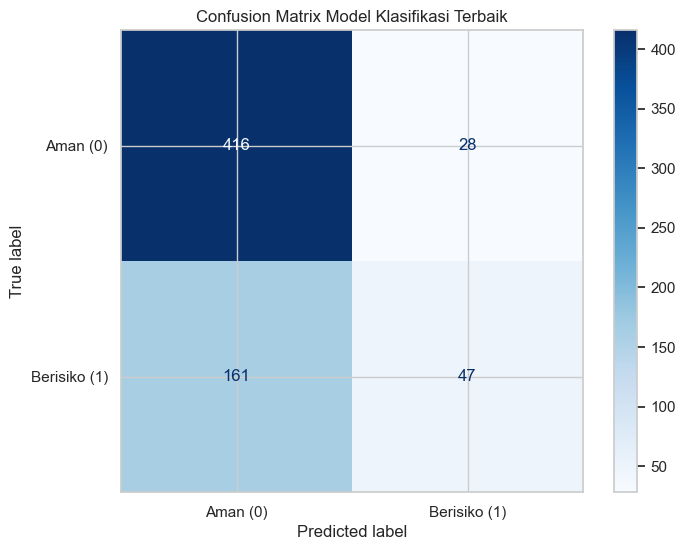

In [176]:
if 'best_clf_model' in locals():
    predictions = best_clf_model.predict(X_test)
    display_labels = ['Aman (0)', 'Berisiko (1)']

    print("\n--- LAPORAN KLASIFIKASI (MODEL TERBAIK) ---")
    report = classification_report(y_test, predictions, target_names=display_labels)
    print(report)

    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title('Confusion Matrix Model Klasifikasi Terbaik')
    plt.show()
else:
    print("\nGagal melanjutkan karena model terbaik tidak ditemukan.")

## 7. Analisis Ambang Batas (Threshold)

In [177]:
if 'best_clf_model' in locals():
    print("\n--- Analisis Trade-Off FN vs FP dengan Berbagai Threshold ---")
    probabilities = best_clf_model.predict_proba(X_test)[:, 1]
    thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

    for th in thresholds:
        pred_binary = (probabilities > th).astype(int)
        cm = confusion_matrix(y_test, pred_binary, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        
        print(f"\n>> Threshold = {th:.1f} | Gagal Deteksi (FN): {fn} | Peringatan Palsu (FP): {fp} | Deteksi Tepat (TP): {tp}")
else:
    print("\nGagal melanjutkan karena model terbaik tidak ditemukan.")


--- Analisis Trade-Off FN vs FP dengan Berbagai Threshold ---

>> Threshold = 0.2 | Gagal Deteksi (FN): 17 | Peringatan Palsu (FP): 215 | Deteksi Tepat (TP): 191

>> Threshold = 0.3 | Gagal Deteksi (FN): 49 | Peringatan Palsu (FP): 113 | Deteksi Tepat (TP): 159

>> Threshold = 0.4 | Gagal Deteksi (FN): 108 | Peringatan Palsu (FP): 62 | Deteksi Tepat (TP): 100

>> Threshold = 0.5 | Gagal Deteksi (FN): 161 | Peringatan Palsu (FP): 28 | Deteksi Tepat (TP): 47

>> Threshold = 0.6 | Gagal Deteksi (FN): 184 | Peringatan Palsu (FP): 12 | Deteksi Tepat (TP): 24

>> Threshold = 0.7 | Gagal Deteksi (FN): 204 | Peringatan Palsu (FP): 1 | Deteksi Tepat (TP): 4


## 10. Laporan Klasifikasi Final dengan Threshold Optimal (0.2)

--- LAPORAN KLASIFIKASI FINAL (Threshold = 0.2) ---
              precision    recall  f1-score   support

    Aman (0)       0.93      0.52      0.66       444
Berisiko (1)       0.47      0.92      0.62       208

    accuracy                           0.64       652
   macro avg       0.70      0.72      0.64       652
weighted avg       0.78      0.64      0.65       652



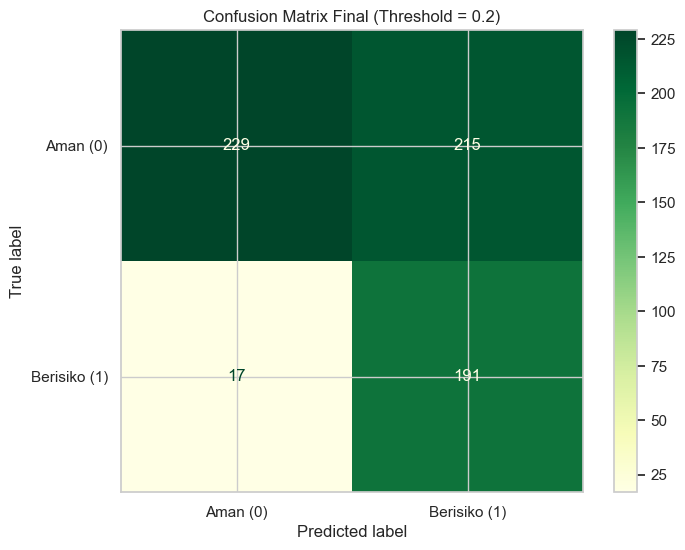

In [ ]:
# Pastikan best_clf_model, X_test, dan y_test sudah ada
if 'best_clf_model' in locals():
    # 1. Dapatkan probabilitas prediksi dari model
    probabilities = best_clf_model.predict_proba(X_test)[:, 1]

    # 2. Terapkan threshold 0.2 untuk membuat prediksi final
    final_predictions = (probabilities > 0.2).astype(int)
    
    # 3. Definisikan label untuk laporan
    display_labels = ['Aman (0)', 'Berisiko (1)']

    # 4. Buat dan tampilkan laporan klasifikasi final
    print("--- LAPORAN KLASIFIKASI FINAL (Threshold = 0.2) ---")
    final_report = classification_report(y_test, final_predictions, target_names=display_labels)
    print(final_report)
    
    # 5. Tampilkan juga Confusion Matrix final
    final_cm = confusion_matrix(y_test, final_predictions)
    disp_final = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=display_labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp_final.plot(ax=ax, cmap='YlGn')
    plt.title('Confusion Matrix Final (Threshold = 0.2)')
    plt.show()

else:
    print("ERROR: Model terbaik 'best_clf_model' tidak ditemukan.")